In [50]:
# Relevant libraries and functions
from __future__ import print_function
import random
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np, h5py
import os, time, sys
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import BatchNormalization, Convolution2D, Input, SpatialDropout2D, UpSampling2D, MaxPooling2D, concatenate
#from keras.layers.core import Activation, Laye#
from keras.layers import Activation, Layer
from keras.layers import Dense, Dropout, Conv1D, Input, Conv2D, add, Conv3D, Reshape
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from itertools import cycle
from sklearn import metrics
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.backend import set_session
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, Conv2DTranspose
plt.style.use('dark_background')

# Load train data

In [51]:
given = False

## Authors' data

In [52]:
if given == True:
        print("pop")
        #f_data = '.../trainData' # Directory with trainging data
        f_data = "/home/antoine/Documents/Code/DL4FLI/FLINET_ex/traindata"
        stacks = os.listdir(f_data)
        numS = int(len(stacks))

        nTG = 160 # Number of time-points
        xX = 28
        yY = 28

        tpsfD = np.ndarray(
                (numS, int(nTG), int(xX), int(yY), int(1)), dtype=np.float32
                )
        t1 = np.ndarray(
                (numS, int(xX), int(yY), int(1)), dtype=np.float32
                )
        t2 = np.ndarray(
                (numS, int(xX), int(yY), int(1)), dtype=np.float32
                )
        tR = np.ndarray(
                (numS, int(xX), int(yY), int(1)), dtype=np.float32
                )

        i = 0
        for d in stacks:
                # Save values to respective mapping
                f = h5py.File(os.path.join(f_data,d),'r') 
                tpsfD[i,:,:,:,0] = f.get('sigD')
                f = h5py.File(os.path.join(f_data,d),'r') 
                t1[i,:,:,0] = f.get('t1')
                f = h5py.File(os.path.join(f_data,d),'r') 
                t2[i,:,:,0] = f.get('t2')
                f = h5py.File(os.path.join(f_data,d),'r') 
                tR[i,:,:,0] = f.get('rT')
                i = i + 1
        
        tpsfD =  np.moveaxis(tpsfD, 1, -2)
        print(tpsfD.shape)

## Data with authors' simulator

In [53]:
if given == False:
        print("pop")
        #f_data = '.../trainData' # Directory with trainging data
        f_data = "/home/antoine/Documents/Code/DL4FLI/FLINET_ex/dataset/authors_like_train.h5"

        nTG = 160 # Number of time-points
        xX = 28
        yY = 28
        numS = 300

        tpsfD = np.ndarray(
                (numS, int(xX), int(yY), int(nTG), int(1)), dtype=np.float32
                )
        t1 = np.ndarray(
                (numS, int(xX), int(yY), int(1)), dtype=np.float32
                )
        t2 = np.ndarray(
                (numS, int(xX), int(yY), int(1)), dtype=np.float32
                )
        tR = np.ndarray(
                (numS, int(xX), int(yY), int(1)), dtype=np.float32
                )


        # Save values to respective mapping
        f = h5py.File(f_data,'r') 
        tpsfD[:,:,:,:,0] = f.get('sigD')
        f = h5py.File(f_data,'r') 
        t1[:,:,:,0] = f.get('t1')
        f = h5py.File(f_data,'r') 
        t2[:,:,:,0] = f.get('t2')
        f = h5py.File(f_data,'r') 
        tR[:,:,:,0] = f.get('rT')

    
#tpsfD =  np.moveaxis(tpsfD, 1, -2)

pop


In [54]:
# Ensure TPSF voxel shape is correct dimensionality (# samples, x, y, time-points, 1)
tpsfD.shape

(300, 28, 28, 160, 1)

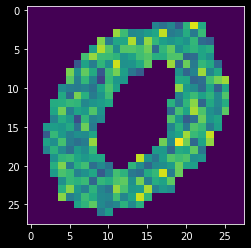

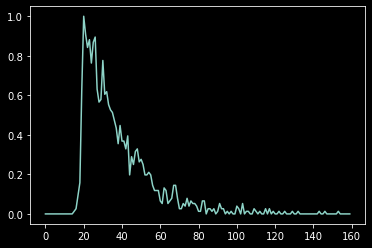

In [55]:
nb = 0
x = 2
y = 21
plt.imshow(tpsfD[nb,:,:,:,0].sum(axis = 2))
plt.figure()
plt.plot(tpsfD[nb,x,y,:,0])

# Train

In [56]:
# Relevant resblock functions (Keras API)
def resblock_2D(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

def resblock_2D_BN(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def resblock_3D_BN(num_filters, size_filter, x):
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def xCeptionblock_2D_BN(num_filters, size_filter, x):
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

In [57]:
modelD = None
xX = 28;
yY = 28;

t_data = Input(shape=(xX, yY, 160,1))
tpsf = t_data

# # # # # # # # 3D-Model # # # # # # # #

tpsf = Conv3D(50,kernel_size=(1,1,10),strides=(1,1,5), padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_3D_BN(50, (1,1,5), tpsf)
tpsf = Reshape((xX,yY,1600))(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)

# Short-lifetime branch
imgT1 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Conv2D(32, 1, padding='same', activation=None)(imgT1)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Conv2D(1, 1, padding='same', activation=None)(imgT1)
imgT1 = Activation('relu', name = "Short_lifetime")(imgT1)

# Long-lifetime branch
imgT2 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Conv2D(32, 1, padding='same', activation=None)(imgT2)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Conv2D(1, 1, padding='same', activation=None)(imgT2)
imgT2 = Activation('relu', name = "Long_lifetime")(imgT2)

# Amplitude-Ratio branch
imgTR = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgTR = BatchNormalization()(imgTR)
imgTR = Activation('relu')(imgTR)
imgTR = Conv2D(32, 1, padding='same', activation=None)(imgTR)
imgTR = BatchNormalization()(imgTR)
imgTR = Activation('relu')(imgTR)
imgTR = Conv2D(1, 1, padding='same', activation=None)(imgTR)
imgTR = Activation('relu',  name = "Ratio")(imgTR)

modelD = Model(inputs=[t_data], outputs=[imgT1,imgT2, imgTR])
rmsprop = RMSprop(learning_rate=1e-5)

modelD.compile(loss='mse',
              optimizer=rmsprop,
              metrics=['mae'])
              
fN = 'testName' # Assign some name for weights and training/validation loss curves here

In [58]:
# Setting patience (patience = 15 recommended)
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 15, 
                              verbose = 0,
                              mode = 'auto')


# Save loss curve (mse) and MAE information over all trained epochs. (monitor = '' can be changed to focus on other tau parameters)
modelCheckPoint = ModelCheckpoint(filepath=fN+'.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
# Train network (80/20 train/validation split, batch_size=20 recommended, nb_epoch may vary based on application)
history = History()
csv_logger = CSVLogger(fN+'.log')
history = modelD.fit([tpsfD], [t1,t2,tR],
          validation_split=0.2,
          batch_size=20, epochs=500, verbose=1, shuffle=True, callbacks=[earlyStopping,csv_logger,modelCheckPoint])

Epoch 1/500
12/12 [==============================] - 25s 2s/step - loss: 0.9008 - Short_lifetime_loss: 0.0920 - Long_lifetime_loss: 0.5080 - Ratio_loss: 0.3007 - Short_lifetime_mae: 0.1515 - Long_lifetime_mae: 0.4183 - Ratio_mae: 0.4212 - val_loss: 0.7767 - val_Short_lifetime_loss: 0.0658 - val_Long_lifetime_loss: 0.5973 - val_Ratio_loss: 0.1137 - val_Short_lifetime_mae: 0.1513 - val_Long_lifetime_mae: 0.4713 - val_Ratio_mae: 0.1993
Epoch 2/500
12/12 [==============================] - 22s 2s/step - loss: 0.7608 - Short_lifetime_loss: 0.0730 - Long_lifetime_loss: 0.4788 - Ratio_loss: 0.2090 - Short_lifetime_mae: 0.1426 - Long_lifetime_mae: 0.4001 - Ratio_mae: 0.3435 - val_loss: 0.7682 - val_Short_lifetime_loss: 0.0658 - val_Long_lifetime_loss: 0.5973 - val_Ratio_loss: 0.1051 - val_Short_lifetime_mae: 0.1513 - val_Long_lifetime_mae: 0.4713 - val_Ratio_mae: 0.2065
Epoch 3/500
12/12 [==============================] - 22s 2s/step - loss: 0.6875 - Short_lifetime_loss: 0.0661 - Long_lifetime_

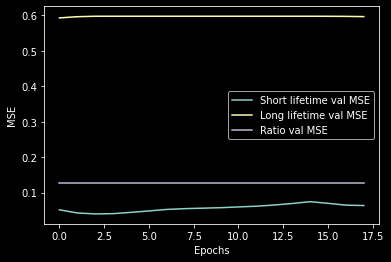

In [ ]:
plt.plot(history.history['val_Short_lifetime_loss'], label='Short lifetime val MSE')
plt.plot(history.history['val_Long_lifetime_loss'], label='Long lifetime val MSE')
plt.plot(history.history['val_Ratio_loss'],label= 'Ratio val MSE')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.savefig("fig/MSE_curves.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/MSE_curves.pdf", dpi = 500, transparent=True, bbox_inches='tight')

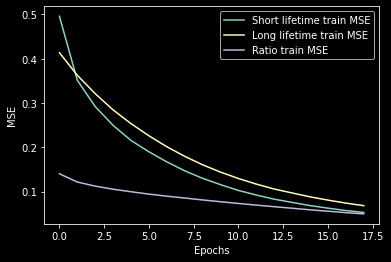

In [ ]:
plt.plot(history.history['Short_lifetime_loss'], label='Short lifetime train MSE')
plt.plot(history.history['Long_lifetime_loss'], label='Long lifetime train MSE')
plt.plot(history.history['Ratio_loss'],label= 'Ratio train MSE')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.savefig("fig/MSE_train_curves.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/MSE_train_curves.pdf", dpi = 500, transparent=True, bbox_inches='tight')

# Load test Data

## Authors' data

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Post-training: load "best" trained weights (obtained through patience - lowest value of loss)
# THIS CAN BE ANY WEIGHT FILE, AS LONG AS THE NETWORK ARCHITECTURE MATCHES THE ONE USED!
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

modelD.load_weights(fN+'.h5')

In [ ]:
# Upload test data and use 3D-CNN for inference
if given == True:
        print('pop')
        t_data = '/home/antoine/Documents/Code/DL4FLI/FLINET_ex/testData' # directory with test data
        stacksT = os.listdir(t_data)
        numT = int(len(stacksT))
        print(numT)

        nTG = 160
        xX = 28
        yY = 28

        tpsfT = np.ndarray(
                (numT, int(nTG), int(xX), int(yY), int(1)), dtype=np.float32
                )
        t1T = np.ndarray(
                (numT, int(xX), int(yY), int(1)), dtype=np.float32
                )
        t2T = np.ndarray(
                (numT, int(xX), int(yY), int(1)), dtype=np.float32
                )
        tRT = np.ndarray(
                (numT, int(xX), int(yY), int(1)), dtype=np.float32
                )

        i = 0;
        for d in stacksT:
                # Save values to respective mapping
                f = h5py.File(os.path.join(t_data,d),'r') 
                tpsfT[i,:,:,:,0] = f.get('sigD')
                f = h5py.File(os.path.join(t_data,d),'r') 
                t1T[i,:,:,0] = f.get('t1')
                f = h5py.File(os.path.join(t_data,d),'r') 
                t2T[i,:,:,0] = f.get('t2')
                f = h5py.File(os.path.join(t_data,d),'r') 
                tRT[i,:,:,0] = f.get('rT')
                i = i + 1
        
        tpsfT =  np.moveaxis(tpsfT, 1, -2)
        print(np.array(tpsfT).shape)

## Data with authors' simulator

In [ ]:
#f_data = '.../trainData' # Directory with trainging data

if given == False:
        f_data = "/home/antoine/Documents/Code/DL4FLI/FLINET_ex/dataset/authors_like_test.h5"
        print('pop')
        nTG = 160 # Number of time-points
        xX = 28
        yY = 28
        numT = 50

        tpsfT = np.ndarray(
                (numT, int(xX), int(yY), int(nTG), int(1)), dtype=np.float32
                )
        t1T = np.ndarray(
                (numT, int(xX), int(yY), int(1)), dtype=np.float32
                )
        t2T = np.ndarray(
                (numT, int(xX), int(yY), int(1)), dtype=np.float32
                )
        tRT = np.ndarray(
                (numT, int(xX), int(yY), int(1)), dtype=np.float32
                )


        # Save values to respective mapping
        f = h5py.File(f_data,'r') 
        tpsfT[:,:,:,:,0] = f.get('sigD')
        f = h5py.File(f_data,'r') 
        t1T[:,:,:,0] = f.get('t1')
        f = h5py.File(f_data,'r') 
        t2T[:,:,:,0] = f.get('t2')
        f = h5py.File(f_data,'r') 
        tRT[:,:,:,0] = f.get('rT')
        print(np.array(tpsfT).shape)
    

# Test

In [ ]:
# Perform inference on test data with trained model
testV = modelD.predict(tpsfT)
t1P = testV[0] # Predicted t1 values
t2P = testV[1] # Predicted t2 values
tRP = testV[2] # Predicted AR values

# Visualize example
n = 3 # Number to illustrate w/ matplotlib
fig = plt.figure(figsize=(10,10))

# Predicted tau1
ax1 = fig.add_subplot(3,2,1)
ax1.imshow(t1P[n,:,:,0], interpolation='nearest', vmin=.2, vmax=.6)
ax1.title.set_text('Predicted tau1')

# G.T. tau1
ax2 = fig.add_subplot(3,2,2)
ax2.imshow(t1T[n,:,:,0], interpolation='nearest', vmin=.2, vmax=.6)
ax2.title.set_text('G.T. tau1')

# Predicted tau2
ax3 = fig.add_subplot(3,2,3)
ax3.imshow(t2P[n,:,:,0], interpolation='nearest', vmin=0.8, vmax=1.5)
ax3.title.set_text('Predicted tau2')
# G.T. tau2
ax4 = fig.add_subplot(3,2,4)
ax4.imshow(t2T[n,:,:,0], interpolation='nearest', vmin=.8, vmax=1.5)
ax4.title.set_text('G.T. tau2')
# Predicted amplitude ratio
ax5 = fig.add_subplot(3,2,5)
ax5.imshow(tRP[n,:,:,0], interpolation='nearest', vmin=0, vmax=1)
ax5.title.set_text('Predicted amplitude ratio')
# G.T. amplitude ratio
ax6 = fig.add_subplot(3,2,6)
ax6.imshow(tRT[n,:,:,0], interpolation='nearest', vmin=0, vmax=1)
ax6.title.set_text('G.T. amplitude ratio')
plt.savefig("fig/out.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/out.pdf", dpi = 500, transparent=True, bbox_inches='tight')

# Pearson

## Tout le jeu de test

In [ ]:
testV = modelD.predict(tpsfT)
t1P = testV[0][:,:,:,0] # Predicted t1 values
t2P = testV[1][:,:,:,0] # Predicted t2 values
tRP = testV[2][:,:,:,0] # Predicted AR values

t1GT = t1T[:,:,:,0] # Ground truth t1 values
t2GT = t2T[:,:,:,0] # Grond truth t2 values
tRGT = tRT[:,:,:,0] # Ground truth AR values

img = tpsfT[:,:,:,:,0].sum(axis = -1)

cloud_t1 = [[],[]]
cloud_t2 = [[],[]]
cloud_tR = [[],[]]
for i in range(numT):
    for x in range(len(img[0])): # On veut la taille de l'image (qui sont carrées) peut importe laquelle
        for y in range(len(img[0])):
            if img[i,x,y] >0:
                cloud_t1[0].append(t1GT[i,x,y])
                cloud_t1[1].append(t1P[i,x,y])
                cloud_t2[0].append(t2GT[i,x,y])
                cloud_t2[1].append(t2P[i,x,y])
                cloud_tR[0].append(tRGT[i,x,y])
                cloud_tR[1].append(tRP[i,x,y])
        
plt.figure()              
plt.scatter(*cloud_t1, label = str(round(np.corrcoef(*cloud_t1)[0,1],3)), edgecolors = "w", c = "orange")
plt.grid(alpha= 0.5, ls = "--")
#plt.xlim(1,1.5)
#plt.ylim(0,2.5)
plt.legend()
plt.xlabel("True short lifetime [ns]")
plt.ylabel("Predicted short lifetime [ns]")
plt.savefig("fig/pearson_cloud_tau1.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/pearson_cloud_tau1.pdf", dpi = 500, transparent=True, bbox_inches='tight')


plt.figure()               
plt.scatter(*cloud_t2, label = str(round(np.corrcoef(*cloud_t2)[0,1],3)), edgecolors = "w", c = "orange")
plt.grid(alpha= 0.5, ls = "--")
#plt.xlim(2,5)
#plt.ylim(0,6)
plt.legend()
plt.xlabel("True long lifetime [ns]")
plt.ylabel("Predicted long lifetime [ns]")
plt.savefig("fig/pearson_cloud_tau1.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/pearson_cloud_tau1.pdf", dpi = 500, transparent=True, bbox_inches='tight')

plt.figure()               
plt.scatter(*cloud_tR, label = str(round(np.corrcoef(*cloud_tR)[0,1],3)), edgecolors = "w", c = "orange")
plt.grid(alpha= 0.5, ls = "--")
#plt.xlim(0,1)
#plt.ylim(0)
plt.legend()
plt.xlabel("True ratio of short lifetime")
plt.ylabel("Predicted ratio of short lifetime")

plt.savefig("fig/pearson_cloud_ratio.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/pearson_cloud_ratio.pdf", dpi = 500, transparent=True, bbox_inches='tight')

## Pearson par image

In [ ]:
testV = modelD.predict(tpsfT)
t1P = testV[0][:,:,:,0] # Predicted t1 values
t2P = testV[1][:,:,:,0] # Predicted t2 values
tRP = testV[2][:,:,:,0] # Predicted AR values

t1GT = t1T[:,:,:,0] # Ground truth t1 values
t2GT = t2T[:,:,:,0] # Grond truth t2 values
tRGT = tRT[:,:,:,0] # Ground truth AR values

img = tpsfT[:,:,:,:,0].sum(axis = -1)

pearson_t1 = []
pearson_t2 = []
pearson_tR = []
for i in range(numT):
    cloud_t1= [[],[]]
    cloud_t2 = [[],[]]
    cloud_tR = [[],[]]
    for x in range(len(img[0])): # On veut la taille de l'image (qui sont carrées) peut importe laquelle
        for y in range(len(img[0])):
            if img[i,x,y] >0:
                cloud_t1[0].append(t1GT[i,x,y])
                cloud_t1[1].append(t1P[i,x,y])
                cloud_t2[0].append(t2GT[i,x,y])
                cloud_t2[1].append(t2P[i,x,y])
                cloud_tR[0].append(tRGT[i,x,y])
                cloud_tR[1].append(tRP[i,x,y])
    pearson_t1.append(np.corrcoef(*cloud_t1)[0,1])
    pearson_t2.append(np.corrcoef(*cloud_t2)[0,1])
    pearson_tR.append(np.corrcoef(*cloud_tR)[0,1])
import seaborn as sns
import pandas as pd
data = {r'$\tau$1': pearson_t1, r'$\tau$2': pearson_t2, 'Ratio': pearson_tR}
data = pd.DataFrame(data = data)
ax = sns.violinplot(data=data)
plt.grid(alpha = 0.5, ls='--')
plt.ylabel("Pearson")
plt.ylim(0,1)
plt.title("Distribtion of Pearsons coefficient over each image")

plt.savefig("fig/pearson_img.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/pearson_img.pdf", dpi = 500, transparent=True, bbox_inches='tight')      

# SSIM

In [ ]:
from skimage.metrics import structural_similarity as ssim
# Perform inference on test data with trained model
testV = modelD.predict(tpsfT)
t1P = testV[0] # Predicted t1 values
t2P = testV[1] # Predicted t2 values
tRP = testV[2] # Predicted AR values

t1_ssim = []
t2_ssim = []
ratio_ssim = []
bins = np.linspace(start=0, stop = 1, endpoint=True, num = 50)

for tau1P, tau2P, ratioP, tau1T, tau2T, ratioT in zip(t1P,t2P,tRP,t1T,t2T,tRT):
    t1_ssim.append(ssim(tau1P[:,:,0],tau1T[:,:,0]))
    t2_ssim.append(ssim(tau2P[:,:,0],tau2T[:,:,0]))
    ratio_ssim.append(ssim(ratioP[:,:,0],ratioT[:,:,0]))

t1_ssim = np.array(t1_ssim)
t2_ssim = np.array(t2_ssim)
ratio_ssim = np.array(ratio_ssim)

plt.hist(t1_ssim, bins = bins, histtype="step", lw = 2, label="Short lifetime")
plt.hist(t2_ssim, bins = bins, histtype="step", lw = 2, label="Long lifetime")
plt.hist(ratio_ssim,bins = bins, histtype="step", lw = 2, label="Ratio")
plt.xlabel("SSIM score")
plt.ylabel("Count")
plt.grid(alpha = 0.5)
plt.legend(loc = "upper left")
plt.savefig("fig/ssim.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/ssim.pdf", dpi = 500, transparent=True, bbox_inches='tight')

# TSNE

In [ ]:
xX = 28;
yY = 28;

t_data = Input(shape=(xX, yY, 160,1))
tpsf = t_data

# # # # # # # # 3D-Model # # # # # # # #

tpsf = Conv3D(50,kernel_size=(1,1,10),strides=(1,1,5), padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_3D_BN(50, (1,1,5), tpsf)
tpsf = Reshape((xX,yY,1600))(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)

model_before = Model(inputs=[t_data], outputs=[tpsf])
rmsprop = RMSprop(learning_rate=1e-5)

model_before.compile(loss='mse',
              optimizer=rmsprop,
              metrics=['mae'])
model_before.load_weights(fN+'.h5', by_name=True)

In [ ]:
print(tpsfT.shape)
print(tpsfT.dtype)

In [ ]:
testV = model_before.predict(tpsfT)

In [ ]:
print(testV.shape)
print(testV.dtype)

In [ ]:
tpsfT_intensity = tpsfT.sum(-1).sum(-1) # On crée un jeu de donnée en intensité mais on se débarrasse aussi de la dernière dimension. Elle est seulement utile pour Keras
data_high = []
tm = []
print(tpsfT_intensity.shape)
for n, image in enumerate(tpsfT_intensity):
    for i,ligne in enumerate(image):
         for j,pixel in enumerate(ligne):
            if pixel>0:
                data_high.append(testV[n][i][j])
                tm.append(tRT[n][i][j] * t1T[n][i][j] + (1 - tRT[n][i][j]) * t2T[n][i][j])
data_high = np.array(data_high).astype(float)
print(data_high.shape)
print(data_high.dtype)

In [ ]:
from sklearn.manifold import TSNE
data_low = TSNE(n_components=2 ,init='random').fit_transform(data_high)

In [ ]:
plt.scatter(*data_low.T, c = tm)
plt.colorbar(label = r"$\tau_m$")
plt.savefig("t_sne.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("t_sne.pdf", dpi = 500, transparent=True, bbox_inches='tight')
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.savefig("fig/t-SNE.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/t-SNE.pdf", dpi = 500, transparent=True, bbox_inches='tight')

In [ ]:
from sklearn.manifold import TSNE
data_low = TSNE(n_components=3 ,init='random').fit_transform(data_high)


In [ ]:
from mpl_toolkits import mplot3d


fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(*data_low.T, c = tm)
#plt.colorbar(label = r"$\tau_m$")
ax.set_xlabel("tSNE 1")
ax.set_ylabel("tSNE 2")
ax.set_zlabel("tSNE 3")
plt.savefig("fig/t-SNE_3d.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/t-SNE_3d.pdf", dpi = 500, transparent=True, bbox_inches='tight')

# Downsamplig

## Train

In [ ]:
# Ensure TPSF voxel shape is correct dimensionality (# samples, x, y, time-points, 1)
X = (tpsfD[:,:,:,:,0] * 2500).astype('int64')
X_down = np.zeros_like(X).astype('float32')
for i, samples in enumerate(X):
    for j, ligne in enumerate(samples):
        for m, pixel in enumerate(ligne):
             res = np.random.binomial(n = pixel, p = 0.1)
             if res.max() != 0:
                res = res/res.max()
             X_down[i,j,m] = res
print(X_down.shape)
tpsfD_down = np.ndarray(
        (numS, int(xX), int(yY), int(nTG), int(1)), dtype=np.float32
        )
tpsfD_down[:,:,:,:,0] = X_down

## Test

In [ ]:
# Ensure TPSF voxel shape is correct dimensionality (# samples, x, y, time-points, 1)
X = (tpsfT[:,:,:,:,0] * 250).astype('int64')
plt.plot(X[5,21,6,:])
X_down = np.zeros_like(X).astype('float32')

count = []
for i, samples in enumerate(X):
    for j, ligne in enumerate(samples):
        for m, pixel in enumerate(ligne):
            res = np.random.binomial(n = pixel, p = 0.04)
            count.append(res.sum())
            if res.max() != 0:
                res = res/res.max()
            X_down[i,j,m] = res
print(X_down.shape)
tpsfT_down = np.ndarray(
        (numT, int(xX), int(yY), int(nTG), int(1)), dtype=np.float32
        )
tpsfT_down[:,:,:,:,0] = X_down
plt.figure()
plt.plot(X_down[5,21,6,:])
print(np.mean(count))
print(np.std(count))

In [ ]:
# Perform inference on test data with trained model
testV = modelD.predict(tpsfT_down)
t1P = testV[0] # Predicted t1 values
t2P = testV[1] # Predicted t2 values
tRP = testV[2] # Predicted AR values

## SSIM

In [ ]:
from skimage.metrics import structural_similarity as ssim
t1_ssim = []
t2_ssim = []
ratio_ssim = []
bins = np.linspace(start=0, stop = 1, endpoint=True, num = 50)

for tau1P, tau2P, ratioP, tau1T, tau2T, ratioT in zip(t1P,t2P,tRP,t1T,t2T,tRT):
    t1_ssim.append(ssim(tau1P[:,:,0],tau1T[:,:,0]))
    t2_ssim.append(ssim(tau2P[:,:,0],tau2T[:,:,0]))
    ratio_ssim.append(ssim(ratioP[:,:,0],ratioT[:,:,0]))

t1_ssim = np.array(t1_ssim)
t2_ssim = np.array(t2_ssim)
ratio_ssim = np.array(ratio_ssim)

plt.hist(t1_ssim, bins = bins, histtype="step", lw = 2, label="Short lifetime")
plt.hist(t2_ssim, bins = bins, histtype="step", lw = 2, label="Long lifetime")
plt.hist(ratio_ssim,bins = bins, histtype="step", lw = 2, label="Ratio")
plt.xlabel("SSIM score")
plt.ylabel("Count")
plt.grid(alpha = 0.5)
plt.legend(loc = "upper left")
plt.savefig("fig/ssim_down.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/ssim_down.pdf", dpi = 500, transparent=True, bbox_inches='tight')

## Pearson

### Tout le jeu de test

In [ ]:
testV = modelD.predict(tpsfT_down)
t1P = testV[0][:,:,:,0] # Predicted t1 values
t2P = testV[1][:,:,:,0] # Predicted t2 values
tRP = testV[2][:,:,:,0] # Predicted AR values

t1GT = t1T[:,:,:,0] # Ground truth t1 values
t2GT = t2T[:,:,:,0] # Grond truth t2 values
tRGT = tRT[:,:,:,0] # Ground truth AR values

img = tpsfT[:,:,:,:,0].sum(axis = -1)

cloud_t1 = [[],[]]
cloud_t2 = [[],[]]
cloud_tR = [[],[]]
for i in range(numT):
    for x in range(len(img[0])): # On veut la taille de l'image (qui sont carrées) peut importe laquelle
        for y in range(len(img[0])):
            if img[i,x,y] >0:
                cloud_t1[0].append(t1GT[i,x,y])
                cloud_t1[1].append(t1P[i,x,y])
                cloud_t2[0].append(t2GT[i,x,y])
                cloud_t2[1].append(t2P[i,x,y])
                cloud_tR[0].append(tRGT[i,x,y])
                cloud_tR[1].append(tRP[i,x,y])
        
plt.figure()              
plt.scatter(*cloud_t1, label = str(round(np.corrcoef(*cloud_t1)[0,1],3)), edgecolors = "w", c = "orange")
plt.grid(alpha= 0.5, ls = "--")
#plt.xlim(1,1.5)
#plt.ylim(0,2.5)
plt.legend()
plt.xlabel("True short lifetime [ns]")
plt.ylabel("Predicted short lifetime [ns]")

plt.figure()               
plt.scatter(*cloud_t2, label = str(round(np.corrcoef(*cloud_t2)[0,1],3)), edgecolors = "w", c = "orange")
plt.grid(alpha= 0.5, ls = "--")
#plt.xlim(2,5)
#plt.ylim(0,6)
plt.legend()
plt.xlabel("True long lifetime [ns]")
plt.ylabel("Predicted long lifetime [ns]")

plt.figure()               
plt.scatter(*cloud_tR, label = str(round(np.corrcoef(*cloud_tR)[0,1],3)), edgecolors = "w", c = "orange")
plt.grid(alpha= 0.5, ls = "--")
#plt.xlim(0,1)
#plt.ylim(0)
plt.legend()
plt.xlabel("True ratio of short lifetime")
plt.ylabel("Predicted ratio of short lifetime")

plt.savefig("fig/pearson_cloud_ratio_down.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/pearson_cloud_ratio_down.pdf", dpi = 500, transparent=True, bbox_inches='tight')

### Pearson par image

In [ ]:
testV = modelD.predict(tpsfT_down)
t1P = testV[0][:,:,:,0] # Predicted t1 values
t2P = testV[1][:,:,:,0] # Predicted t2 values
tRP = testV[2][:,:,:,0] # Predicted AR values

t1GT = t1T[:,:,:,0] # Ground truth t1 values
t2GT = t2T[:,:,:,0] # Grond truth t2 values
tRGT = tRT[:,:,:,0] # Ground truth AR values

img = tpsfT[:,:,:,:,0].sum(axis = -1)

pearson_t1 = []
pearson_t2 = []
pearson_tR = []
for i in range(numT):
    cloud_t1= [[],[]]
    cloud_t2 = [[],[]]
    cloud_tR = [[],[]]
    for x in range(len(img[0])): # On veut la taille de l'image (qui sont carrées) peut importe laquelle
        for y in range(len(img[0])):
            if img[i,x,y] >0:
                cloud_t1[0].append(t1GT[i,x,y])
                cloud_t1[1].append(t1P[i,x,y])
                cloud_t2[0].append(t2GT[i,x,y])
                cloud_t2[1].append(t2P[i,x,y])
                cloud_tR[0].append(tRGT[i,x,y])
                cloud_tR[1].append(tRP[i,x,y])
    pearson_t1.append(np.corrcoef(*cloud_t1)[0,1])
    pearson_t2.append(np.corrcoef(*cloud_t2)[0,1])
    pearson_tR.append(np.corrcoef(*cloud_tR)[0,1])
import seaborn as sns
import pandas as pd
data = {r'$\tau$1': pearson_t1, r'$\tau$2': pearson_t2, 'Ratio': pearson_tR}
data = pd.DataFrame(data = data)
ax = sns.violinplot(data = data)
plt.grid(alpha = 0.5, ls='--')
plt.ylim(0,1)
plt.ylabel("Pearson")


plt.savefig("fig/pearson_img_down.png", dpi = 500, transparent=True, bbox_inches='tight')
plt.savefig("fig/pearson_img_down.pdf", dpi = 500, transparent=True, bbox_inches='tight')      